# Interactive Data Tutorial

## *Welcome to the ChAMP Data Interactive Demo!*

#### Herein we share a link to our step-by-step tutorial for analyzing movement data extracted using the ChAMP app. 

![](logo.png)

#### Before beginning, you must download our open-access dataset of ChAMP data or collect your own data using the ChAMP mobile application. 

To request download access for the ChAMP mobile application to collect your own dataset, please fill out [this form](https://forms.office.com/r/PEfwybkiAM) or scan this QR code.
![](QR.png)

*need to add link:* To download the open access dataset already collected by our team, go [here](). 

##### To begin, run each of the cells by hovering over the [  ] symbol under the header and clicking the play button that appears or click "Run All" in the Runtime tab.

## Start Imports

In [1]:
! pip install ptitprince
! pip install pingouin
! pip install seaborn
! pip install pandas
! pip install scipy
! pip install datetime
! pip install re
! pip install matplotlib
! pip install numpy
! pip install glob

import glob
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
import re
from datetime import datetime
import scipy
from scipy import signal
import pandas as pd
import seaborn as sns
import ptitprince as pt
import pingouin as pg


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement re (from versions: none)
ERROR: No matching distribution found for re
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/cola

## Functions

In [17]:
def find_magnitudes(name1,name2,name3,file):
    one = file[name1].values.tolist()
    two = file[name2].values.tolist()
    three = file[name3].values.tolist()
    
    vector_list = []
    for x in range(len(one)):
        new = np.array([one[x],two[x],three[x]])
        vector_list.append(new)

    magnitude_list = []
    for x in range(len(vector_list)):
        magnitude = np.linalg.norm(vector_list[x])
        magnitude_list.append(magnitude)
    return magnitude_list

def clean_datalog(champ_dataLog):
    champ_dataLog.columns = ['test','timestamp','gyro1','gyro2','gyro3','acc1','acc2','acc3']
    champ_dataLog.drop(columns = 'test')

    gyro_mags = find_magnitudes('gyro1','gyro2','gyro3',champ_dataLog)
    acc_mags = find_magnitudes('acc1','acc2','acc3',champ_dataLog)

    champ_dataLog['gyro_mag'] = gyro_mags
    champ_dataLog['acc_mag'] = acc_mags

    champ_dataLog = champ_dataLog.drop(columns = ['gyro1','gyro2','gyro3','acc1','acc2','acc3'])

    return champ_dataLog

def clean_actionlog(champ_actionLog):
    champ_actionLog.columns = ['action_recorded','timestamp','action','note']
    champ_actionLog = champ_actionLog.drop(columns = ['action_recorded','note'])
    return champ_actionLog

def create_new_lists(signal,timestamps):
    new_signal = []
    new_timestamp = []
    for x in range(len(signal)):
        if np.isnan(signal[x]) == False:
            new_signal.append(signal[x])
            new_timestamp.append(timestamps[x])
    return new_signal,new_timestamp

def create_converted_timestamp(timestamp_column_name,data_column_name,data_and_demographics):
    new_timestamps = []
    new_list = []
    for x in data_and_demographics[timestamp_column_name]:
        new_list = [y-x[0] for y in x]
        new_timestamps.append(new_list)
    
    data_list = list(data_and_demographics[data_column_name].values)

    actual_lists_timestamp = []
    actual_data_list = []
    for x in range(len(new_timestamps)):
        had_to_be_fixed = False
        for y in range(0,len(new_timestamps[x])-1):
            if new_timestamps[x][y+1]-new_timestamps[x][y] > 100:
                had_to_be_fixed = True
                new_truncation = new_timestamps[x][:y]
                actual_lists_timestamp.append(new_truncation)
                new_data_truncation = data_list[x][:y]
                actual_data_list.append(new_data_truncation)
                break
        if had_to_be_fixed == False:
            actual_lists_timestamp.append(new_timestamps[x])
            actual_data_list.append(data_list[x])
    return actual_lists_timestamp, actual_data_list

def box_plot(data, fill_color,i,ax):
    bp = ax.boxplot(data, patch_artist=True,positions = [i],widths = .75,medianprops=dict(color='black'),flierprops = dict(color = fill_color))
    for box in bp['boxes']:
        box.set(color='black', linewidth=2)
    for fliers in bp['fliers']:
        flierprops=dict(color= fill_color, markeredgecolor='fill_color')
    #for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    #    plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color,alpha = .6)       
        
    return bp

def box_plot_no_fliers(data, fill_color,i,ax):
    bp = ax.boxplot(data, patch_artist=True,positions = [i],widths = .75,medianprops=dict(color='black'),showfliers=False)
    for box in bp['boxes']:
        box.set(color='black', linewidth=2)
    for fliers in bp['fliers']:
        flierprops=dict(color= fill_color, markeredgecolor='fill_color')
    #for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    #    plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color,alpha = .6)       
        
    return bp
def barplot_annotate_brackets(num1, num2, data, center, height, yerr=None, dh=.055, barh=.055, fs=None, maxasterix=None):
    if type(data) is str:
        text = data
    else:
        # * is p < 0.05, ** is p < 0.005, *** is p < 0.0005, etc.
        text = 'P = ' + str(data.round(4))
        
    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]
    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]
    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)
    y = max(ly, ry) + dh
    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)
    plt.plot(barx, bary, c='black')
    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs
    plt.text(*mid, text, **kwargs)

def test_difference_KSADSgen(test_list,data_and_demographics):
    sig_list = []
   
    print('KSADSintDX >0 vs 1')

    affected = data_and_demographics[data_and_demographics['KSADSintDX'] == 1]
    unaffected = data_and_demographics[data_and_demographics['KSADSintDX'] == 0]
    print(len(affected),len(unaffected))

    for list_item in test_list:
        affected_list = list(affected[list_item].values)
        unaffected_list = list(unaffected[list_item].values)
        u, p = scipy.stats.mannwhitneyu(affected_list,unaffected_list)
        if p < .1:
            if list_item not in sig_list:
                sig_list.append(list_item)       
                new_df = pd.DataFrame(columns = ['data','type'])
                for x in affected_list:
                    new_df.loc[len(new_df.index)] = [x,'affected']
                for x in unaffected_list:
                    new_df.loc[len(new_df.index)] = [x,'unaffected']
                print(p)
                print(np.median(affected_list),np.median(unaffected_list))
                fig,ax = plt.subplots(1,figsize = (4,4))
                pt.half_violinplot(data = new_df,y = 'data',x = 'type',palette = ['#D81B60','whitesmoke'],linewidth = 2,inner = None,width = .9,cut = 0)
                sns.boxplot(data = new_df,y = 'data',x = 'type',palette = ['#D81B60','whitesmoke'],fliersize = 8,linewidth = 1.5,width = .2,flierprops = {'linewidth':2, "zorder":10,'marker':'.','alpha' : .9})
                barplot_annotate_brackets(0,1,p,[-.13,.9],[max([max(unaffected_list),max(affected_list)]),1],maxasterix=7,fs = 16)
                plt.xlabel('')
                plt.yticks(fontsize = 16)
                plt.ylabel(list_item,fontsize = 15)
                plt.xticks([-.1,.93],['Affected','Unaffected'],fontsize = 15)
                #ax.spines.right.set_visible(False)
                #ax.spines.top.set_visible(False)
                plt.tick_params(
                    axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    labelbottom=True) # labels along the bottom edge are off
                print(list_item)
                print()
                plt.show()


    return sig_list


## Start File Pulls

### Mount the Sample KID Data or mount your own folder!

In [3]:
from google.colab import drive
drive.mount('/content/drive/')
!cd '/content/drive/MyDrive/CHAMP/data'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Gather Data from Folder

In [5]:
#declare needed lists
data_files = []
action_files = []
data_subjects = []
action_subjects = []

#pull in champ files
for name in glob.glob("/content/drive/MyDrive/CHAMP/data/*"):
    file_path = name
    name = name.replace('/content/drive/MyDrive/CHAMP/data/','')
    if "actionLog" in name:
        name = name.replace('.actionLog.projectmHealth.csv','')
        remove = "\\real"
        name = ''.join( c for c in name if c not in remove )
        action_subject = name.lower()
        file_contents  = pd.read_csv(file_path, header = 0, sep = ',')
        action_files.append(file_contents)
        action_subjects.append(action_subject)
    if "dataLog" in name: 
        name = name.replace('.dataLog.projectmHealth.csv','')
        remove = "\\real"
        name = ''.join( c for c in name if c not in remove )
        data_subject = name.lower()
        file_contents  = pd.read_csv(file_path, header = 0,usecols = ['Test','Timestamp','Gyro 1','Gyro 2','Gyro 3','Acc 1','Acc 2', 'Acc 3'])
        data_files.append(file_contents)
        data_subjects.append(data_subject)

#pull in redcap file
for name in glob.glob("/content/drive/MyDrive/CHAMP/data/*"):
    if 'RedCapforBryn' in name:
        redcap  = pd.read_csv(name, header = 0, sep = ',')

### Perform Data Cleaning on Subject ID's to Prep for Merge

In [6]:
#remove leading zeros and 'S' from subject IDs

redcap['childid'] = [x.lower() for x in redcap['childid']]
list_of_redcap_ids = redcap['childid'].values

B = [x[1:] for x in list_of_redcap_ids]
list_of_redcap_ids = [ele.lstrip('0') for ele in B]
redcap['childid'] = list_of_redcap_ids

B = [x[1:] for x in data_subjects]
data_subjects = [ele.lstrip('0') for ele in B]

B = [x[1:] for x in action_subjects]
action_subjects = [ele.lstrip('0') for ele in B]

#remove subjects we don't have data for
redcap = redcap[redcap['childid'].isin(data_subjects)]

In [7]:
new_action_files = []
new_data_files = []
for file in range(len(data_files)):
    converted_action_file = clean_actionlog(action_files[file])
    new_action_files.append(converted_action_file)

    converted_data_file = clean_datalog(data_files[file])
    new_data_files.append(converted_data_file)
action_files = new_action_files
data_files = new_data_files

In [8]:
redcap = redcap[['childid','childageMonths','childageYears','childgender1','CBCLintGmax','KSADSintSX', 'KSADSintDX','Diagnosis']]

### Merge Demographic Data and CHAMP Data

In [9]:
holder_list_bubs = []
holder_list_apro = []

for x in range(len(data_files)):
    grouped = data_files[x].groupby(data_files[x].test)
    tests = list(set(data_files[x]['test']))
    approach_gyro = []
    approach_gyro_timestamp = []
    approach_acc = []
    approach_acc_timestamp = []
    for y in tests:
        if y == 1:
            approach_gyro = list(grouped.get_group(y)['gyro_mag'].values)
            approach_acc = list(grouped.get_group(y)['acc_mag'].values)
            approach_gyro_timestamp = list(grouped.get_group(y)['timestamp'].values)
            approach_acc_timestamp = list(grouped.get_group(y)['timestamp'].values)

        if y == 3:
            bubbles_gyro = list(grouped.get_group(y)['gyro_mag'].values)
            bubbles_acc = list(grouped.get_group(y)['acc_mag'].values)
            bubbles_gyro_timestamp = list(grouped.get_group(y)['timestamp'].values)
            bubbles_acc_timestamp = list(grouped.get_group(y)['timestamp'].values)

    bubbles_gyro, bubbles_gyro_timestamp = create_new_lists(bubbles_gyro,bubbles_gyro_timestamp)
    new_addition = [data_subjects[x],bubbles_gyro,bubbles_gyro_timestamp,bubbles_acc,bubbles_acc_timestamp]
    holder_list_bubs.append(new_addition)
    
    approach_gyro, approach_gyro_timestamp = create_new_lists(approach_gyro,approach_gyro_timestamp)
    approach_acc, approach_acc_timestamp = create_new_lists(approach_acc,approach_acc_timestamp)
    
    new_addition = [data_subjects[x],approach_gyro,approach_gyro_timestamp,approach_acc,approach_acc_timestamp]
    holder_list_apro.append(new_addition)
holder_frame_approach = pd.DataFrame(data = holder_list_bubs,columns = ['childid','approach_gyro','approach_gyro_timestamp','approach_acc','approach_acc_timestamp'])
holder_frame_bubbs = pd.DataFrame(data = holder_list_apro,columns = ['childid','bubbles_gyro','bubbles_gyro_timestamp','bubbles_acc','bubbles_acc_timestamp'])

data_and_demographics = pd.merge(redcap,holder_frame_approach,how = 'left',on = 'childid')
data_and_demographics = pd.merge(data_and_demographics,holder_frame_bubbs,how = 'left',on = 'childid')

In [10]:
data_and_demographics['bubbles_gyro_timestamp'],data_and_demographics['bubbles_gyro'] = create_converted_timestamp('bubbles_gyro_timestamp','bubbles_gyro',data_and_demographics)
data_and_demographics['bubbles_acc_timestamp'],data_and_demographics['bubbles_acc'] = create_converted_timestamp('bubbles_acc_timestamp','bubbles_acc',data_and_demographics)
data_and_demographics['approach_gyro_timestamp'],data_and_demographics['approach_gyro'] = create_converted_timestamp('approach_gyro_timestamp','approach_gyro',data_and_demographics)
data_and_demographics['approach_acc_timestamp'],data_and_demographics['approach_acc'] = create_converted_timestamp('approach_acc_timestamp','approach_acc',data_and_demographics)

### Create Features

In [11]:
gyro_data_list_0_5 = []
gyro_data_list_5_10 = []
gyro_data_list_10_15 = []
gyro_data_list_15_19 = []
gyro_data_list_19_22 = []
gyro_data_list_22_25 = []
gyro_data_list_25_30 = []
gyro_data_list_0_19 =[]
gyro_data_list_5_19 = []
gyro_data_list_19_25 = []

acc_data_list_0_5 = []
acc_data_list_5_10 = []
acc_data_list_10_15 = []
acc_data_list_15_19 = []
acc_data_list_19_22 = []
acc_data_list_22_25 = []
acc_data_list_25_30 = []
acc_data_list_0_19 =[]
acc_data_list_5_19 = []
acc_data_list_19_25 = []

gyro_timestamp_list_0_5 = []
gyro_timestamp_list_5_10 = []
gyro_timestamp_list_10_15 = []
gyro_timestamp_list_15_19 = []
gyro_timestamp_list_19_22 = []
gyro_timestamp_list_22_25 = []
gyro_timestamp_list_25_30 = []
gyro_timestamp_list_0_19 =[]
gyro_timestamp_list_5_19 = []
gyro_timestamp_list_19_25 = []

acc_timestamp_list_0_5 = []
acc_timestamp_list_5_10 = []
acc_timestamp_list_10_15 = []
acc_timestamp_list_15_19 = []
acc_timestamp_list_19_22 = []
acc_timestamp_list_22_25 = []
acc_timestamp_list_25_30 = []
acc_timestamp_list_0_19 =[]
acc_timestamp_list_5_19 = []
acc_timestamp_list_19_25 = []
#[0-5],[5-10],[10-15],[15-19],[19-22],[22-25],[25-30]
for x in range(len(data_and_demographics['approach_gyro'])):
    gyro_data_list_0_5.append(list(data_and_demographics['approach_gyro'].iloc[x])[0:(5*300)])
    gyro_data_list_5_10.append(list(data_and_demographics['approach_gyro'].iloc[x])[(5*300):(10*300)])
    gyro_data_list_10_15.append(list(data_and_demographics['approach_gyro'].iloc[x])[(10*300):(15*300)])
    gyro_data_list_15_19.append(list(data_and_demographics['approach_gyro'].iloc[x])[(15*300):(19*300)])
    gyro_data_list_19_22.append(list(data_and_demographics['approach_gyro'].iloc[x])[(19*300):(22*300)])
    gyro_data_list_22_25.append(list(data_and_demographics['approach_gyro'].iloc[x])[(22*300):(25*300)])
    gyro_data_list_25_30.append(list(data_and_demographics['approach_gyro'].iloc[x])[(25*300):])
    gyro_data_list_0_19.append(list(data_and_demographics['approach_gyro'].iloc[x])[0:(19*300)])
    gyro_data_list_5_19.append(list(data_and_demographics['approach_gyro'].iloc[x])[(5*300):(19*300)])
    gyro_data_list_19_25.append(list(data_and_demographics['approach_gyro'].iloc[x])[(19*300):(25*300)])

    acc_data_list_0_5.append(list(data_and_demographics['approach_acc'].iloc[x])[0:(5*300)])
    acc_data_list_5_10.append(list(data_and_demographics['approach_acc'].iloc[x])[(5*300):(10*300)])
    acc_data_list_10_15.append(list(data_and_demographics['approach_acc'].iloc[x])[(10*300):(15*300)])
    acc_data_list_15_19.append(list(data_and_demographics['approach_acc'].iloc[x])[(15*300):(19*300)])
    acc_data_list_19_22.append(list(data_and_demographics['approach_acc'].iloc[x])[(19*300):(22*300)])
    acc_data_list_22_25.append(list(data_and_demographics['approach_acc'].iloc[x])[(22*300):(25*300)])
    acc_data_list_25_30.append(list(data_and_demographics['approach_acc'].iloc[x])[(25*300):])
    acc_data_list_0_19.append(list(data_and_demographics['approach_acc'].iloc[x])[0:(19*300)])
    acc_data_list_5_19.append(list(data_and_demographics['approach_acc'].iloc[x])[(5*300):(19*300)])
    acc_data_list_19_25.append(list(data_and_demographics['approach_acc'].iloc[x])[(19*300):(25*300)])

    gyro_timestamp_list_0_5.append(list(data_and_demographics['approach_gyro_timestamp'].iloc[x])[0:(5*300)])
    gyro_timestamp_list_5_10.append(list(data_and_demographics['approach_gyro_timestamp'].iloc[x])[(5*300):(10*300)])
    gyro_timestamp_list_10_15.append(list(data_and_demographics['approach_gyro_timestamp'].iloc[x])[(10*300):(15*300)])
    gyro_timestamp_list_15_19.append(list(data_and_demographics['approach_gyro_timestamp'].iloc[x])[(15*300):(19*300)])
    gyro_timestamp_list_19_22.append(list(data_and_demographics['approach_gyro_timestamp'].iloc[x])[(19*300):(22*300)])
    gyro_timestamp_list_22_25.append(list(data_and_demographics['approach_gyro_timestamp'].iloc[x])[(22*300):(25*300)])
    gyro_timestamp_list_25_30.append(list(data_and_demographics['approach_gyro_timestamp'].iloc[x])[(25*300):])
    gyro_timestamp_list_0_19.append(list(data_and_demographics['approach_gyro_timestamp'].iloc[x])[0:(19*300)])
    gyro_timestamp_list_5_19.append(list(data_and_demographics['approach_gyro_timestamp'].iloc[x])[(5*300):(19*300)])
    gyro_timestamp_list_19_25.append(list(data_and_demographics['approach_gyro_timestamp'].iloc[x])[(19*300):(25*300)])

    acc_timestamp_list_0_5.append(list(data_and_demographics['approach_acc_timestamp'].iloc[x])[0:(5*300)])
    acc_timestamp_list_5_10.append(list(data_and_demographics['approach_acc_timestamp'].iloc[x])[(5*300):(10*300)])
    acc_timestamp_list_10_15.append(list(data_and_demographics['approach_acc_timestamp'].iloc[x])[(10*300):(15*300)])
    acc_timestamp_list_15_19.append(list(data_and_demographics['approach_acc_timestamp'].iloc[x])[(15*300):(19*300)])
    acc_timestamp_list_19_22.append(list(data_and_demographics['approach_acc_timestamp'].iloc[x])[(19*300):(22*300)])
    acc_timestamp_list_22_25.append(list(data_and_demographics['approach_acc_timestamp'].iloc[x])[(22*300):(25*300)])
    acc_timestamp_list_25_30.append(list(data_and_demographics['approach_acc_timestamp'].iloc[x])[(25*300):])
    acc_timestamp_list_0_19.append(list(data_and_demographics['approach_acc_timestamp'].iloc[x])[0:(19*300)])
    acc_timestamp_list_5_19.append(list(data_and_demographics['approach_acc_timestamp'].iloc[x])[(5*300):(19*300)])
    acc_timestamp_list_19_25.append(list(data_and_demographics['approach_acc_timestamp'].iloc[x])[(19*300):(25*300)])



data_and_demographics['gyro_data_list_0_5'] = gyro_data_list_0_5
data_and_demographics['gyro_data_list_5_10'] = gyro_data_list_5_10
data_and_demographics['gyro_data_list_10_15'] = gyro_data_list_10_15
data_and_demographics['gyro_data_list_15_19'] = gyro_data_list_15_19
data_and_demographics['gyro_data_list_19_22'] = gyro_data_list_19_22
data_and_demographics['gyro_data_list_22_25'] = gyro_data_list_22_25
data_and_demographics['gyro_data_list_25_30'] = gyro_data_list_25_30
data_and_demographics['gyro_data_list_0_19'] = gyro_data_list_0_19
data_and_demographics['gyro_data_list_5_19'] = gyro_data_list_5_19
data_and_demographics['gyro_data_list_19_25'] = gyro_data_list_19_25

data_and_demographics['acc_data_list_0_5'] = acc_data_list_0_5
data_and_demographics['acc_data_list_5_10'] = acc_data_list_5_10
data_and_demographics['acc_data_list_10_15'] = acc_data_list_10_15
data_and_demographics['acc_data_list_15_19'] = acc_data_list_15_19
data_and_demographics['acc_data_list_19_22'] = acc_data_list_19_22
data_and_demographics['acc_data_list_22_25'] = acc_data_list_22_25
data_and_demographics['acc_data_list_25_30'] = acc_data_list_25_30
data_and_demographics['acc_data_list_0_19'] = acc_data_list_0_19
data_and_demographics['acc_data_list_5_19'] = acc_data_list_5_19
data_and_demographics['acc_data_list_19_25'] = acc_data_list_19_25

data_and_demographics['gyro_timestamp_list_0_5'] = gyro_timestamp_list_0_5
data_and_demographics['gyro_timestamp_list_5_10'] = gyro_timestamp_list_5_10
data_and_demographics['gyro_timestamp_list_10_15'] = gyro_timestamp_list_10_15
data_and_demographics['gyro_timestamp_list_15_19'] = gyro_timestamp_list_15_19
data_and_demographics['gyro_timestamp_list_19_22'] = gyro_timestamp_list_19_22
data_and_demographics['gyro_timestamp_list_22_25'] = gyro_timestamp_list_22_25
data_and_demographics['gyro_timestamp_list_25_30'] = gyro_timestamp_list_25_30
data_and_demographics['gyro_timestamp_list_0_19'] = gyro_timestamp_list_0_19
data_and_demographics['gyro_timestamp_list_5_19'] = gyro_timestamp_list_5_19
data_and_demographics['gyro_timestamp_list_19_25'] = gyro_timestamp_list_19_25

data_and_demographics['acc_timestamp_list_0_5'] = acc_timestamp_list_0_5
data_and_demographics['acc_timestamp_list_5_10'] = acc_timestamp_list_5_10
data_and_demographics['acc_timestamp_list_10_15'] = acc_timestamp_list_10_15
data_and_demographics['acc_timestamp_list_15_19'] = acc_timestamp_list_15_19
data_and_demographics['acc_timestamp_list_19_22'] = acc_timestamp_list_19_22
data_and_demographics['acc_timestamp_list_22_25'] = acc_timestamp_list_22_25
data_and_demographics['acc_timestamp_list_25_30'] = acc_timestamp_list_25_30
data_and_demographics['acc_timestamp_list_0_19'] = acc_timestamp_list_0_19
data_and_demographics['acc_timestamp_list_5_19'] = acc_timestamp_list_5_19
data_and_demographics['acc_timestamp_list_19_25'] = acc_timestamp_list_19_25

In [12]:
first_bubbles_gyro_data_list = []
second_bubbles_gyro_data_list = []
third_bubbles_gyro_data_list = []
four_bubbles_gyro_data_list = []
five_bubbles_gyro_data_list = []
six_bubbles_gyro_data_list = []
seven_bubbles_gyro_data_list = []
eight_bubbles_gyro_data_list = []
nine_bubbles_gyro_data_list = []
ten_bubbles_gyro_data_list = []
eleven_bubbles_gyro_data_list = []
twelve_bubbles_gyro_data_list = []
first_bubbles_acc_data_list= []
second_bubbles_acc_data_list= []
third_bubbles_acc_data_list= []
four_bubbles_acc_data_list= []
five_bubbles_acc_data_list= []
six_bubbles_acc_data_list= []
seven_bubbles_acc_data_list= []
eight_bubbles_acc_data_list= []
nine_bubbles_acc_data_list= []
ten_bubbles_acc_data_list= []
eleven_bubbles_acc_data_list= []
twelve_bubbles_acc_data_list= []
first_bubbles_gyro_timestamp_list= []
second_bubbles_gyro_timestamp_list= []
third_bubbles_gyro_timestamp_list= []
four_bubbles_gyro_timestamp_list= []
five_bubbles_gyro_timestamp_list= []
six_bubbles_gyro_timestamp_list= []
seven_bubbles_gyro_timestamp_list= []
eight_bubbles_gyro_timestamp_list= []
nine_bubbles_gyro_timestamp_list= []
ten_bubbles_gyro_timestamp_list= []
eleven_bubbles_gyro_timestamp_list= []
twelve_bubbles_gyro_timestamp_list= []
first_bubbles_acc_timestamp_list= []
second_bubbles_acc_timestamp_list= []
third_bubbles_acc_timestamp_list= []
four_bubbles_acc_timestamp_list= []
five_bubbles_acc_timestamp_list= []
six_bubbles_acc_timestamp_list= []
seven_bubbles_acc_timestamp_list= []
eight_bubbles_acc_timestamp_list= []
nine_bubbles_acc_timestamp_list= []
ten_bubbles_acc_timestamp_list= []
eleven_bubbles_acc_timestamp_list= []
twelve_bubbles_acc_timestamp_list= []



for x in range(len(data_and_demographics['childid'])):
    first_bubbles_gyro_data,second_bubbles_gyro_data,third_bubbles_gyro_data,four_bubbles_gyro_data,five_bubbles_gyro_data,six_bubbles_gyro_data,seven_bubbles_gyro_data,eight_bubbles_gyro_data,nine_bubbles_gyro_data,ten_bubbles_gyro_data,eleven_bubbles_gyro_data,twelve_bubbles_gyro_data = np.array_split(list(data_and_demographics['bubbles_gyro'].iloc[x]), 12)
    first_bubbles_acc_data,second_bubbles_acc_data,third_bubbles_acc_data,four_bubbles_acc_data,five_bubbles_acc_data,six_bubbles_acc_data,seven_bubbles_acc_data,eight_bubbles_acc_data,nine_bubbles_acc_data,ten_bubbles_acc_data,eleven_bubbles_acc_data,twelve_bubbles_acc_data = np.array_split(list(data_and_demographics['bubbles_acc'].iloc[x]), 12)
    first_bubbles_gyro_timestamp,second_bubbles_gyro_timestamp,third_bubbles_gyro_timestamp,four_bubbles_gyro_timestamp,five_bubbles_gyro_timestamp,six_bubbles_gyro_timestamp,seven_bubbles_gyro_timestamp,eight_bubbles_gyro_timestamp,nine_bubbles_gyro_timestamp,ten_bubbles_gyro_timestamp,eleven_bubbles_gyro_timestamp,twelve_bubbles_gyro_timestamp = np.array_split(list(data_and_demographics['bubbles_gyro_timestamp'].iloc[x]), 12)
    first_bubbles_acc_timestamp,second_bubbles_acc_timestamp,third_bubbles_acc_timestamp,four_bubbles_acc_timestamp,five_bubbles_acc_timestamp,six_bubbles_acc_timestamp,seven_bubbles_acc_timestamp,eight_bubbles_acc_timestamp,nine_bubbles_acc_timestamp,ten_bubbles_acc_timestamp,eleven_bubbles_acc_timestamp,twelve_bubbles_acc_timestamp = np.array_split(list(data_and_demographics['bubbles_acc_timestamp'].iloc[x]), 12)

    first_bubbles_gyro_data_list.append(first_bubbles_gyro_data)
    second_bubbles_gyro_data_list.append(second_bubbles_gyro_data)
    third_bubbles_gyro_data_list.append(third_bubbles_gyro_data)
    four_bubbles_gyro_data_list.append(four_bubbles_gyro_data)
    five_bubbles_gyro_data_list.append(five_bubbles_gyro_data)
    six_bubbles_gyro_data_list.append(six_bubbles_gyro_data)
    seven_bubbles_gyro_data_list.append(seven_bubbles_gyro_data)
    eight_bubbles_gyro_data_list.append(eight_bubbles_gyro_data)
    nine_bubbles_gyro_data_list.append(nine_bubbles_gyro_data)
    ten_bubbles_gyro_data_list.append(ten_bubbles_gyro_data)
    eleven_bubbles_gyro_data_list.append(eleven_bubbles_gyro_data)
    twelve_bubbles_gyro_data_list.append(twelve_bubbles_gyro_data)

    first_bubbles_acc_data_list.append(first_bubbles_acc_data)
    second_bubbles_acc_data_list.append(second_bubbles_acc_data)
    third_bubbles_acc_data_list.append(third_bubbles_acc_data)
    four_bubbles_acc_data_list.append(four_bubbles_acc_data)
    five_bubbles_acc_data_list.append(five_bubbles_acc_data)
    six_bubbles_acc_data_list.append(six_bubbles_acc_data)
    seven_bubbles_acc_data_list.append(seven_bubbles_acc_data)
    eight_bubbles_acc_data_list.append(eight_bubbles_acc_data)
    nine_bubbles_acc_data_list.append(nine_bubbles_acc_data)
    ten_bubbles_acc_data_list.append(ten_bubbles_acc_data)
    eleven_bubbles_acc_data_list.append(eleven_bubbles_acc_data)
    twelve_bubbles_acc_data_list.append(twelve_bubbles_acc_data)

    first_bubbles_gyro_timestamp_list.append(first_bubbles_gyro_timestamp)
    second_bubbles_gyro_timestamp_list.append(second_bubbles_gyro_timestamp)
    third_bubbles_gyro_timestamp_list.append(third_bubbles_gyro_timestamp)
    four_bubbles_gyro_timestamp_list.append(four_bubbles_gyro_timestamp)
    five_bubbles_gyro_timestamp_list.append(five_bubbles_gyro_timestamp)
    six_bubbles_gyro_timestamp_list.append(six_bubbles_gyro_timestamp)
    seven_bubbles_gyro_timestamp_list.append(seven_bubbles_gyro_timestamp)
    eight_bubbles_gyro_timestamp_list.append(eight_bubbles_gyro_timestamp)
    nine_bubbles_gyro_timestamp_list.append(nine_bubbles_gyro_timestamp)
    ten_bubbles_gyro_timestamp_list.append(ten_bubbles_gyro_timestamp)
    eleven_bubbles_gyro_timestamp_list.append(eleven_bubbles_gyro_timestamp)
    twelve_bubbles_gyro_timestamp_list.append(twelve_bubbles_gyro_timestamp)

    first_bubbles_acc_timestamp_list.append(first_bubbles_acc_timestamp)
    second_bubbles_acc_timestamp_list.append(second_bubbles_acc_timestamp)
    third_bubbles_acc_timestamp_list.append(third_bubbles_acc_timestamp)
    four_bubbles_acc_timestamp_list.append(four_bubbles_acc_timestamp)
    five_bubbles_acc_timestamp_list.append(five_bubbles_acc_timestamp)
    six_bubbles_acc_timestamp_list.append(six_bubbles_acc_timestamp)
    seven_bubbles_acc_timestamp_list.append(seven_bubbles_acc_timestamp)
    eight_bubbles_acc_timestamp_list.append(eight_bubbles_acc_timestamp)
    nine_bubbles_acc_timestamp_list.append(nine_bubbles_acc_timestamp)
    ten_bubbles_acc_timestamp_list.append(ten_bubbles_acc_timestamp)
    eleven_bubbles_acc_timestamp_list.append(eleven_bubbles_acc_timestamp)
    twelve_bubbles_acc_timestamp_list.append(twelve_bubbles_acc_timestamp)

data_and_demographics['one_bubbles_gyro_data'] = first_bubbles_gyro_data_list
data_and_demographics['two_bubbles_gyro_data'] = second_bubbles_gyro_data_list
data_and_demographics['three_bubbles_gyro_data'] = third_bubbles_gyro_data_list
data_and_demographics['four_bubbles_gyro_data'] = four_bubbles_gyro_data_list
data_and_demographics['five_bubbles_gyro_data'] = five_bubbles_gyro_data_list
data_and_demographics['six_bubbles_gyro_data'] = six_bubbles_gyro_data_list
data_and_demographics['seven_bubbles_gyro_data'] = seven_bubbles_gyro_data_list
data_and_demographics['eight_bubbles_gyro_data'] = eight_bubbles_gyro_data_list
data_and_demographics['nine_bubbles_gyro_data'] = nine_bubbles_gyro_data_list
data_and_demographics['ten_bubbles_gyro_data'] = ten_bubbles_gyro_data_list
data_and_demographics['eleven_bubbles_gyro_data'] = eleven_bubbles_gyro_data_list
data_and_demographics['twelve_bubbles_gyro_data'] = twelve_bubbles_gyro_data_list

data_and_demographics['one_bubbles_acc_data'] = first_bubbles_acc_data_list
data_and_demographics['two_bubbles_acc_data'] = second_bubbles_acc_data_list
data_and_demographics['three_bubbles_acc_data'] = third_bubbles_acc_data_list
data_and_demographics['four_bubbles_acc_data'] = four_bubbles_acc_data_list
data_and_demographics['five_bubbles_acc_data'] = five_bubbles_acc_data_list
data_and_demographics['six_bubbles_acc_data'] = six_bubbles_acc_data_list
data_and_demographics['seven_bubbles_acc_data'] = seven_bubbles_acc_data_list
data_and_demographics['eight_bubbles_acc_data'] = eight_bubbles_acc_data_list
data_and_demographics['nine_bubbles_acc_data'] = nine_bubbles_acc_data_list
data_and_demographics['ten_bubbles_acc_data'] = ten_bubbles_acc_data_list
data_and_demographics['eleven_bubbles_acc_data'] = eleven_bubbles_acc_data_list
data_and_demographics['twelve_bubbles_acc_data'] = twelve_bubbles_acc_data_list

data_and_demographics['one_bubbles_gyro_timestamp'] = first_bubbles_gyro_timestamp_list
data_and_demographics['two_bubbles_gyro_timestamp'] = second_bubbles_gyro_timestamp_list
data_and_demographics['three_bubbles_gyro_timestamp'] = third_bubbles_gyro_timestamp_list
data_and_demographics['four_bubbles_gyro_timestamp'] = four_bubbles_gyro_timestamp_list
data_and_demographics['five_bubbles_gyro_timestamp'] = five_bubbles_gyro_timestamp_list
data_and_demographics['six_bubbles_gyro_timestamp'] = six_bubbles_gyro_timestamp_list
data_and_demographics['seven_bubbles_gyro_timestamp'] = seven_bubbles_gyro_timestamp_list
data_and_demographics['eight_bubbles_gyro_timestamp'] = eight_bubbles_gyro_timestamp_list
data_and_demographics['nine_bubbles_gyro_timestamp'] = nine_bubbles_gyro_timestamp_list
data_and_demographics['ten_bubbles_gyro_timestamp'] = ten_bubbles_gyro_timestamp_list
data_and_demographics['eleven_bubbles_gyro_timestamp'] = eleven_bubbles_gyro_timestamp_list
data_and_demographics['twelve_bubbles_gyro_timestamp'] = twelve_bubbles_gyro_timestamp_list

data_and_demographics['one_bubbles_acc_timestamp'] = first_bubbles_acc_timestamp_list
data_and_demographics['two_bubbles_acc_timestamp'] = second_bubbles_acc_timestamp_list
data_and_demographics['three_bubbles_acc_timestamp'] = third_bubbles_acc_timestamp_list
data_and_demographics['four_bubbles_acc_timestamp'] = four_bubbles_acc_timestamp_list
data_and_demographics['five_bubbles_acc_timestamp'] = five_bubbles_acc_timestamp_list
data_and_demographics['six_bubbles_acc_timestamp'] = six_bubbles_acc_timestamp_list
data_and_demographics['seven_bubbles_acc_timestamp'] = seven_bubbles_acc_timestamp_list
data_and_demographics['eight_bubbles_acc_timestamp'] = eight_bubbles_acc_timestamp_list
data_and_demographics['nine_bubbles_acc_timestamp'] = nine_bubbles_acc_timestamp_list
data_and_demographics['ten_bubbles_acc_timestamp'] = ten_bubbles_acc_timestamp_list
data_and_demographics['eleven_bubbles_acc_timestamp'] = eleven_bubbles_acc_timestamp_list
data_and_demographics['twelve_bubbles_acc_timestamp'] = twelve_bubbles_acc_timestamp_list



In [13]:
data_and_demographics['median_bubbles_acc_0-15'] = [np.median(x) for x in data_and_demographics['one_bubbles_acc_data']]
data_and_demographics['median_bubbles_acc_15-30'] = [np.median(x) for x in data_and_demographics['two_bubbles_acc_data']]
data_and_demographics['median_bubbles_acc_30-45'] = [np.median(x) for x in data_and_demographics['three_bubbles_acc_data']]
data_and_demographics['median_bubbles_acc_45-60'] = [np.median(x) for x in data_and_demographics['four_bubbles_acc_data']]
data_and_demographics['median_bubbles_acc_60-75'] = [np.median(x) for x in data_and_demographics['five_bubbles_acc_data']]
data_and_demographics['median_bubbles_acc_75-90'] = [np.median(x) for x in data_and_demographics['six_bubbles_acc_data']]
data_and_demographics['median_bubbles_acc_90-105'] = [np.median(x) for x in data_and_demographics['seven_bubbles_acc_data']]
data_and_demographics['median_bubbles_acc_105-120'] = [np.median(x) for x in data_and_demographics['eight_bubbles_acc_data']]
data_and_demographics['median_bubbles_acc_120-135'] = [np.median(x) for x in data_and_demographics['nine_bubbles_acc_data']]
data_and_demographics['median_bubbles_acc_135-150'] = [np.median(x) for x in data_and_demographics['ten_bubbles_acc_data']]
data_and_demographics['median_bubbles_acc_150-165'] = [np.median(x) for x in data_and_demographics['eleven_bubbles_acc_data']]
data_and_demographics['median_bubbles_acc_165-180'] = [np.median(x) for x in data_and_demographics['twelve_bubbles_acc_data']]

data_and_demographics['median_bubbles_gyro_0-15'] = [np.median(x) for x in data_and_demographics['one_bubbles_gyro_data']]
data_and_demographics['median_bubbles_gyro_15-30'] = [np.median(x) for x in data_and_demographics['two_bubbles_gyro_data']]
data_and_demographics['median_bubbles_gyro_30-45'] = [np.median(x) for x in data_and_demographics['three_bubbles_gyro_data']]
data_and_demographics['median_bubbles_gyro_45-60'] = [np.median(x) for x in data_and_demographics['four_bubbles_gyro_data']]
data_and_demographics['median_bubbles_gyro_60-75'] = [np.median(x) for x in data_and_demographics['five_bubbles_gyro_data']]
data_and_demographics['median_bubbles_gyro_75-90'] = [np.median(x) for x in data_and_demographics['six_bubbles_gyro_data']]
data_and_demographics['median_bubbles_gyro_90-105'] = [np.median(x) for x in data_and_demographics['seven_bubbles_gyro_data']]
data_and_demographics['median_bubbles_gyro_105-120'] = [np.median(x) for x in data_and_demographics['eight_bubbles_gyro_data']]
data_and_demographics['median_bubbles_gyro_120-135'] = [np.median(x) for x in data_and_demographics['nine_bubbles_gyro_data']]
data_and_demographics['median_bubbles_gyro_135-150'] = [np.median(x) for x in data_and_demographics['ten_bubbles_gyro_data']]
data_and_demographics['median_bubbles_gyro_150-165'] = [np.median(x) for x in data_and_demographics['eleven_bubbles_gyro_data']]
data_and_demographics['median_bubbles_gyro_165-180'] = [np.median(x) for x in data_and_demographics['twelve_bubbles_gyro_data']]

data_and_demographics['sum_bubbles_acc_0-15'] = [np.sum(x) for x in data_and_demographics['one_bubbles_acc_data']]
data_and_demographics['sum_bubbles_acc_15-30'] = [np.sum(x) for x in data_and_demographics['two_bubbles_acc_data']]
data_and_demographics['sum_bubbles_acc_30-45'] = [np.sum(x) for x in data_and_demographics['three_bubbles_acc_data']]
data_and_demographics['sum_bubbles_acc_45-60'] = [np.sum(x) for x in data_and_demographics['four_bubbles_acc_data']]
data_and_demographics['sum_bubbles_acc_60-75'] = [np.sum(x) for x in data_and_demographics['five_bubbles_acc_data']]
data_and_demographics['sum_bubbles_acc_75-90'] = [np.sum(x) for x in data_and_demographics['six_bubbles_acc_data']]
data_and_demographics['sum_bubbles_acc_90-105'] = [np.sum(x) for x in data_and_demographics['seven_bubbles_acc_data']]
data_and_demographics['sum_bubbles_acc_105-120'] = [np.sum(x) for x in data_and_demographics['eight_bubbles_acc_data']]
data_and_demographics['sum_bubbles_acc_120-135'] = [np.sum(x) for x in data_and_demographics['nine_bubbles_acc_data']]
data_and_demographics['sum_bubbles_acc_135-150'] = [np.sum(x) for x in data_and_demographics['ten_bubbles_acc_data']]
data_and_demographics['sum_bubbles_acc_150-165'] = [np.sum(x) for x in data_and_demographics['eleven_bubbles_acc_data']]
data_and_demographics['sum_bubbles_acc_165-180'] = [np.sum(x) for x in data_and_demographics['twelve_bubbles_acc_data']]

data_and_demographics['sum_bubbles_gyro_0-15'] = [np.sum(x) for x in data_and_demographics['one_bubbles_gyro_data']]
data_and_demographics['sum_bubbles_gyro_15-30'] = [np.sum(x) for x in data_and_demographics['two_bubbles_gyro_data']]
data_and_demographics['sum_bubbles_gyro_30-45'] = [np.sum(x) for x in data_and_demographics['three_bubbles_gyro_data']]
data_and_demographics['sum_bubbles_gyro_45-60'] = [np.sum(x) for x in data_and_demographics['four_bubbles_gyro_data']]
data_and_demographics['sum_bubbles_gyro_60-75'] = [np.sum(x) for x in data_and_demographics['five_bubbles_gyro_data']]
data_and_demographics['sum_bubbles_gyro_75-90'] = [np.sum(x) for x in data_and_demographics['six_bubbles_gyro_data']]
data_and_demographics['sum_bubbles_gyro_90-105'] = [np.sum(x) for x in data_and_demographics['seven_bubbles_gyro_data']]
data_and_demographics['sum_bubbles_gyro_105-120'] = [np.sum(x) for x in data_and_demographics['eight_bubbles_gyro_data']]
data_and_demographics['sum_bubbles_gyro_120-135'] = [np.sum(x) for x in data_and_demographics['nine_bubbles_gyro_data']]
data_and_demographics['sum_bubbles_gyro_135-150'] = [np.sum(x) for x in data_and_demographics['ten_bubbles_gyro_data']]
data_and_demographics['sum_bubbles_gyro_150-165'] = [np.sum(x) for x in data_and_demographics['eleven_bubbles_gyro_data']]
data_and_demographics['sum_bubbles_gyro_165-180'] = [np.sum(x) for x in data_and_demographics['twelve_bubbles_gyro_data']]

data_and_demographics['95p_bubbles_acc_0-15'] = [np.percentile(x,95) for x in data_and_demographics['one_bubbles_acc_data']]
data_and_demographics['95p_bubbles_acc_15-30'] = [np.percentile(x,95) for x in data_and_demographics['two_bubbles_acc_data']]
data_and_demographics['95p_bubbles_acc_30-45'] = [np.percentile(x,95) for x in data_and_demographics['three_bubbles_acc_data']]
data_and_demographics['95p_bubbles_acc_45-60'] = [np.percentile(x,95) for x in data_and_demographics['four_bubbles_acc_data']]
data_and_demographics['95p_bubbles_acc_60-75'] = [np.percentile(x,95) for x in data_and_demographics['five_bubbles_acc_data']]
data_and_demographics['95p_bubbles_acc_75-90'] = [np.percentile(x,95) for x in data_and_demographics['six_bubbles_acc_data']]
data_and_demographics['95p_bubbles_acc_90-105'] = [np.percentile(x,95) for x in data_and_demographics['seven_bubbles_acc_data']]
data_and_demographics['95p_bubbles_acc_105-120'] = [np.percentile(x,95) for x in data_and_demographics['eight_bubbles_acc_data']]
data_and_demographics['95p_bubbles_acc_120-135'] = [np.percentile(x,95) for x in data_and_demographics['nine_bubbles_acc_data']]
data_and_demographics['95p_bubbles_acc_135-150'] = [np.percentile(x,95) for x in data_and_demographics['ten_bubbles_acc_data']]
data_and_demographics['95p_bubbles_acc_150-165'] = [np.percentile(x,95) for x in data_and_demographics['eleven_bubbles_acc_data']]
data_and_demographics['95p_bubbles_acc_165-180'] = [np.percentile(x,95) for x in data_and_demographics['twelve_bubbles_acc_data']]

data_and_demographics['95p_bubbles_gyro_0-15'] = [np.percentile(x,95) for x in data_and_demographics['one_bubbles_gyro_data']]
data_and_demographics['95p_bubbles_gyro_15-30'] = [np.percentile(x,95) for x in data_and_demographics['two_bubbles_gyro_data']]
data_and_demographics['95p_bubbles_gyro_30-45'] = [np.percentile(x,95) for x in data_and_demographics['three_bubbles_gyro_data']]
data_and_demographics['95p_bubbles_gyro_45-60'] = [np.percentile(x,95) for x in data_and_demographics['four_bubbles_gyro_data']]
data_and_demographics['95p_bubbles_gyro_60-75'] = [np.percentile(x,95) for x in data_and_demographics['five_bubbles_gyro_data']]
data_and_demographics['95p_bubbles_gyro_75-90'] = [np.percentile(x,95) for x in data_and_demographics['six_bubbles_gyro_data']]
data_and_demographics['95p_bubbles_gyro_90-105'] = [np.percentile(x,95) for x in data_and_demographics['seven_bubbles_gyro_data']]
data_and_demographics['95p_bubbles_gyro_105-120'] = [np.percentile(x,95) for x in data_and_demographics['eight_bubbles_gyro_data']]
data_and_demographics['95p_bubbles_gyro_120-135'] = [np.percentile(x,95) for x in data_and_demographics['nine_bubbles_gyro_data']]
data_and_demographics['95p_bubbles_gyro_135-150'] = [np.percentile(x,95) for x in data_and_demographics['ten_bubbles_gyro_data']]
data_and_demographics['95p_bubbles_gyro_150-165'] = [np.percentile(x,95) for x in data_and_demographics['eleven_bubbles_gyro_data']]
data_and_demographics['95p_bubbles_gyro_165-180'] = [np.percentile(x,95) for x in data_and_demographics['twelve_bubbles_gyro_data']]

data_and_demographics['5p_bubbles_acc_0-15'] = [np.percentile(x,5) for x in data_and_demographics['one_bubbles_acc_data']]
data_and_demographics['5p_bubbles_acc_15-30'] = [np.percentile(x,5) for x in data_and_demographics['two_bubbles_acc_data']]
data_and_demographics['5p_bubbles_acc_30-45'] = [np.percentile(x,5) for x in data_and_demographics['three_bubbles_acc_data']]
data_and_demographics['5p_bubbles_acc_45-60'] = [np.percentile(x,5) for x in data_and_demographics['four_bubbles_acc_data']]
data_and_demographics['5p_bubbles_acc_60-75'] = [np.percentile(x,5) for x in data_and_demographics['five_bubbles_acc_data']]
data_and_demographics['5p_bubbles_acc_75-90'] = [np.percentile(x,5) for x in data_and_demographics['six_bubbles_acc_data']]
data_and_demographics['5p_bubbles_acc_90-105'] = [np.percentile(x,5) for x in data_and_demographics['seven_bubbles_acc_data']]
data_and_demographics['5p_bubbles_acc_105-120'] = [np.percentile(x,5) for x in data_and_demographics['eight_bubbles_acc_data']]
data_and_demographics['5p_bubbles_acc_120-135'] = [np.percentile(x,5) for x in data_and_demographics['nine_bubbles_acc_data']]
data_and_demographics['5p_bubbles_acc_135-150'] = [np.percentile(x,5) for x in data_and_demographics['ten_bubbles_acc_data']]
data_and_demographics['5p_bubbles_acc_150-165'] = [np.percentile(x,5) for x in data_and_demographics['eleven_bubbles_acc_data']]
data_and_demographics['5p_bubbles_acc_165-180'] = [np.percentile(x,5) for x in data_and_demographics['twelve_bubbles_acc_data']]

data_and_demographics['5p_bubbles_gyro_0-15'] = [np.percentile(x,5) for x in data_and_demographics['one_bubbles_gyro_data']]
data_and_demographics['5p_bubbles_gyro_15-30'] = [np.percentile(x,5) for x in data_and_demographics['two_bubbles_gyro_data']]
data_and_demographics['5p_bubbles_gyro_30-45'] = [np.percentile(x,5) for x in data_and_demographics['three_bubbles_gyro_data']]
data_and_demographics['5p_bubbles_gyro_45-60'] = [np.percentile(x,5) for x in data_and_demographics['four_bubbles_gyro_data']]
data_and_demographics['5p_bubbles_gyro_60-75'] = [np.percentile(x,5) for x in data_and_demographics['five_bubbles_gyro_data']]
data_and_demographics['5p_bubbles_gyro_75-90'] = [np.percentile(x,5) for x in data_and_demographics['six_bubbles_gyro_data']]
data_and_demographics['5p_bubbles_gyro_90-105'] = [np.percentile(x,5) for x in data_and_demographics['seven_bubbles_gyro_data']]
data_and_demographics['5p_bubbles_gyro_105-120'] = [np.percentile(x,5) for x in data_and_demographics['eight_bubbles_gyro_data']]
data_and_demographics['5p_bubbles_gyro_120-135'] = [np.percentile(x,5) for x in data_and_demographics['nine_bubbles_gyro_data']]
data_and_demographics['5p_bubbles_gyro_135-150'] = [np.percentile(x,5) for x in data_and_demographics['ten_bubbles_gyro_data']]
data_and_demographics['5p_bubbles_gyro_150-165'] = [np.percentile(x,5) for x in data_and_demographics['eleven_bubbles_gyro_data']]
data_and_demographics['5p_bubbles_gyro_165-180'] = [np.percentile(x,5) for x in data_and_demographics['twelve_bubbles_gyro_data']]

data_and_demographics['75p_bubbles_acc_0-15'] = [np.percentile(x,75) for x in data_and_demographics['one_bubbles_acc_data']]
data_and_demographics['75p_bubbles_acc_15-30'] = [np.percentile(x,75) for x in data_and_demographics['two_bubbles_acc_data']]
data_and_demographics['75p_bubbles_acc_30-45'] = [np.percentile(x,75) for x in data_and_demographics['three_bubbles_acc_data']]
data_and_demographics['75p_bubbles_acc_45-60'] = [np.percentile(x,75) for x in data_and_demographics['four_bubbles_acc_data']]
data_and_demographics['75p_bubbles_acc_60-75'] = [np.percentile(x,75) for x in data_and_demographics['five_bubbles_acc_data']]
data_and_demographics['75p_bubbles_acc_75-90'] = [np.percentile(x,75) for x in data_and_demographics['six_bubbles_acc_data']]
data_and_demographics['75p_bubbles_acc_90-105'] = [np.percentile(x,75) for x in data_and_demographics['seven_bubbles_acc_data']]
data_and_demographics['75p_bubbles_acc_105-120'] = [np.percentile(x,75) for x in data_and_demographics['eight_bubbles_acc_data']]
data_and_demographics['75p_bubbles_acc_120-135'] = [np.percentile(x,75) for x in data_and_demographics['nine_bubbles_acc_data']]
data_and_demographics['75p_bubbles_acc_135-150'] = [np.percentile(x,75) for x in data_and_demographics['ten_bubbles_acc_data']]
data_and_demographics['75p_bubbles_acc_150-165'] = [np.percentile(x,75) for x in data_and_demographics['eleven_bubbles_acc_data']]
data_and_demographics['75p_bubbles_acc_165-180'] = [np.percentile(x,75) for x in data_and_demographics['twelve_bubbles_acc_data']]

data_and_demographics['75p_bubbles_gyro_0-15'] = [np.percentile(x,75) for x in data_and_demographics['one_bubbles_gyro_data']]
data_and_demographics['75p_bubbles_gyro_15-30'] = [np.percentile(x,75) for x in data_and_demographics['two_bubbles_gyro_data']]
data_and_demographics['75p_bubbles_gyro_30-45'] = [np.percentile(x,75) for x in data_and_demographics['three_bubbles_gyro_data']]
data_and_demographics['75p_bubbles_gyro_45-60'] = [np.percentile(x,75) for x in data_and_demographics['four_bubbles_gyro_data']]
data_and_demographics['75p_bubbles_gyro_60-75'] = [np.percentile(x,75) for x in data_and_demographics['five_bubbles_gyro_data']]
data_and_demographics['75p_bubbles_gyro_75-90'] = [np.percentile(x,75) for x in data_and_demographics['six_bubbles_gyro_data']]
data_and_demographics['75p_bubbles_gyro_90-105'] = [np.percentile(x,75) for x in data_and_demographics['seven_bubbles_gyro_data']]
data_and_demographics['75p_bubbles_gyro_105-120'] = [np.percentile(x,75) for x in data_and_demographics['eight_bubbles_gyro_data']]
data_and_demographics['75p_bubbles_gyro_120-135'] = [np.percentile(x,75) for x in data_and_demographics['nine_bubbles_gyro_data']]
data_and_demographics['75p_bubbles_gyro_135-150'] = [np.percentile(x,75) for x in data_and_demographics['ten_bubbles_gyro_data']]
data_and_demographics['75p_bubbles_gyro_150-165'] = [np.percentile(x,75) for x in data_and_demographics['eleven_bubbles_gyro_data']]
data_and_demographics['75p_bubbles_gyro_165-180'] = [np.percentile(x,75) for x in data_and_demographics['twelve_bubbles_gyro_data']]

data_and_demographics['25p_bubbles_acc_0-15'] = [np.percentile(x,25) for x in data_and_demographics['one_bubbles_acc_data']]
data_and_demographics['25p_bubbles_acc_15-30'] = [np.percentile(x,25) for x in data_and_demographics['two_bubbles_acc_data']]
data_and_demographics['25p_bubbles_acc_30-45'] = [np.percentile(x,25) for x in data_and_demographics['three_bubbles_acc_data']]
data_and_demographics['25p_bubbles_acc_45-60'] = [np.percentile(x,25) for x in data_and_demographics['four_bubbles_acc_data']]
data_and_demographics['25p_bubbles_acc_60-75'] = [np.percentile(x,25) for x in data_and_demographics['five_bubbles_acc_data']]
data_and_demographics['25p_bubbles_acc_75-90'] = [np.percentile(x,25) for x in data_and_demographics['six_bubbles_acc_data']]
data_and_demographics['25p_bubbles_acc_90-105'] = [np.percentile(x,25) for x in data_and_demographics['seven_bubbles_acc_data']]
data_and_demographics['25p_bubbles_acc_105-120'] = [np.percentile(x,25) for x in data_and_demographics['eight_bubbles_acc_data']]
data_and_demographics['25p_bubbles_acc_120-135'] = [np.percentile(x,25) for x in data_and_demographics['nine_bubbles_acc_data']]
data_and_demographics['25p_bubbles_acc_135-150'] = [np.percentile(x,25) for x in data_and_demographics['ten_bubbles_acc_data']]
data_and_demographics['25p_bubbles_acc_150-165'] = [np.percentile(x,25) for x in data_and_demographics['eleven_bubbles_acc_data']]
data_and_demographics['25p_bubbles_acc_165-180'] = [np.percentile(x,25) for x in data_and_demographics['twelve_bubbles_acc_data']]

data_and_demographics['25p_bubbles_gyro_0-15'] = [np.percentile(x,25) for x in data_and_demographics['one_bubbles_gyro_data']]
data_and_demographics['25p_bubbles_gyro_15-30'] = [np.percentile(x,25) for x in data_and_demographics['two_bubbles_gyro_data']]
data_and_demographics['25p_bubbles_gyro_30-45'] = [np.percentile(x,25) for x in data_and_demographics['three_bubbles_gyro_data']]
data_and_demographics['25p_bubbles_gyro_45-60'] = [np.percentile(x,25) for x in data_and_demographics['four_bubbles_gyro_data']]
data_and_demographics['25p_bubbles_gyro_60-75'] = [np.percentile(x,25) for x in data_and_demographics['five_bubbles_gyro_data']]
data_and_demographics['25p_bubbles_gyro_75-90'] = [np.percentile(x,25) for x in data_and_demographics['six_bubbles_gyro_data']]
data_and_demographics['25p_bubbles_gyro_90-105'] = [np.percentile(x,25) for x in data_and_demographics['seven_bubbles_gyro_data']]
data_and_demographics['25p_bubbles_gyro_105-120'] = [np.percentile(x,25) for x in data_and_demographics['eight_bubbles_gyro_data']]
data_and_demographics['25p_bubbles_gyro_120-135'] = [np.percentile(x,25) for x in data_and_demographics['nine_bubbles_gyro_data']]
data_and_demographics['25p_bubbles_gyro_135-150'] = [np.percentile(x,25) for x in data_and_demographics['ten_bubbles_gyro_data']]
data_and_demographics['25p_bubbles_gyro_150-165'] = [np.percentile(x,25) for x in data_and_demographics['eleven_bubbles_gyro_data']]
data_and_demographics['25p_bubbles_gyro_165-180'] = [np.percentile(x,25) for x in data_and_demographics['twelve_bubbles_gyro_data']]

data_and_demographics['std_bubbles_acc_0-15'] = [np.std(x) for x in data_and_demographics['one_bubbles_acc_data']]
data_and_demographics['std_bubbles_acc_15-30'] = [np.std(x) for x in data_and_demographics['two_bubbles_acc_data']]
data_and_demographics['std_bubbles_acc_30-45'] = [np.std(x) for x in data_and_demographics['three_bubbles_acc_data']]
data_and_demographics['std_bubbles_acc_45-60'] = [np.std(x) for x in data_and_demographics['four_bubbles_acc_data']]
data_and_demographics['std_bubbles_acc_60-75'] = [np.std(x) for x in data_and_demographics['five_bubbles_acc_data']]
data_and_demographics['std_bubbles_acc_75-90'] = [np.std(x) for x in data_and_demographics['six_bubbles_acc_data']]
data_and_demographics['std_bubbles_acc_90-105'] = [np.std(x) for x in data_and_demographics['seven_bubbles_acc_data']]
data_and_demographics['std_bubbles_acc_105-120'] = [np.std(x) for x in data_and_demographics['eight_bubbles_acc_data']]
data_and_demographics['std_bubbles_acc_120-135'] = [np.std(x) for x in data_and_demographics['nine_bubbles_acc_data']]
data_and_demographics['std_bubbles_acc_135-150'] = [np.std(x) for x in data_and_demographics['ten_bubbles_acc_data']]
data_and_demographics['std_bubbles_acc_150-165'] = [np.std(x) for x in data_and_demographics['eleven_bubbles_acc_data']]
data_and_demographics['std_bubbles_acc_165-180'] = [np.std(x) for x in data_and_demographics['twelve_bubbles_acc_data']]

data_and_demographics['std_bubbles_gyro_0-15'] = [np.std(x) for x in data_and_demographics['one_bubbles_gyro_data']]
data_and_demographics['std_bubbles_gyro_15-30'] = [np.std(x) for x in data_and_demographics['two_bubbles_gyro_data']]
data_and_demographics['std_bubbles_gyro_30-45'] = [np.std(x) for x in data_and_demographics['three_bubbles_gyro_data']]
data_and_demographics['std_bubbles_gyro_45-60'] = [np.std(x) for x in data_and_demographics['four_bubbles_gyro_data']]
data_and_demographics['std_bubbles_gyro_60-75'] = [np.std(x) for x in data_and_demographics['five_bubbles_gyro_data']]
data_and_demographics['std_bubbles_gyro_75-90'] = [np.std(x) for x in data_and_demographics['six_bubbles_gyro_data']]
data_and_demographics['std_bubbles_gyro_90-105'] = [np.std(x) for x in data_and_demographics['seven_bubbles_gyro_data']]
data_and_demographics['std_bubbles_gyro_105-120'] = [np.std(x) for x in data_and_demographics['eight_bubbles_gyro_data']]
data_and_demographics['std_bubbles_gyro_120-135'] = [np.std(x) for x in data_and_demographics['nine_bubbles_gyro_data']]
data_and_demographics['std_bubbles_gyro_135-150'] = [np.std(x) for x in data_and_demographics['ten_bubbles_gyro_data']]
data_and_demographics['std_bubbles_gyro_150-165'] = [np.std(x) for x in data_and_demographics['eleven_bubbles_gyro_data']]
data_and_demographics['std_bubbles_gyro_165-180'] = [np.std(x) for x in data_and_demographics['twelve_bubbles_gyro_data']]

data_and_demographics['var_bubbles_acc_0-15'] = [np.var(x) for x in data_and_demographics['one_bubbles_acc_data']]
data_and_demographics['var_bubbles_acc_15-30'] = [np.var(x) for x in data_and_demographics['two_bubbles_acc_data']]
data_and_demographics['var_bubbles_acc_30-45'] = [np.var(x) for x in data_and_demographics['three_bubbles_acc_data']]
data_and_demographics['var_bubbles_acc_45-60'] = [np.var(x) for x in data_and_demographics['four_bubbles_acc_data']]
data_and_demographics['var_bubbles_acc_60-75'] = [np.var(x) for x in data_and_demographics['five_bubbles_acc_data']]
data_and_demographics['var_bubbles_acc_75-90'] = [np.var(x) for x in data_and_demographics['six_bubbles_acc_data']]
data_and_demographics['var_bubbles_acc_90-105'] = [np.var(x) for x in data_and_demographics['seven_bubbles_acc_data']]
data_and_demographics['var_bubbles_acc_105-120'] = [np.var(x) for x in data_and_demographics['eight_bubbles_acc_data']]
data_and_demographics['var_bubbles_acc_120-135'] = [np.var(x) for x in data_and_demographics['nine_bubbles_acc_data']]
data_and_demographics['var_bubbles_acc_135-150'] = [np.var(x) for x in data_and_demographics['ten_bubbles_acc_data']]
data_and_demographics['var_bubbles_acc_150-165'] = [np.var(x) for x in data_and_demographics['eleven_bubbles_acc_data']]
data_and_demographics['var_bubbles_acc_165-180'] = [np.var(x) for x in data_and_demographics['twelve_bubbles_acc_data']]

data_and_demographics['var_bubbles_gyro_0-15'] = [np.var(x) for x in data_and_demographics['one_bubbles_gyro_data']]
data_and_demographics['var_bubbles_gyro_15-30'] = [np.var(x) for x in data_and_demographics['two_bubbles_gyro_data']]
data_and_demographics['var_bubbles_gyro_30-45'] = [np.var(x) for x in data_and_demographics['three_bubbles_gyro_data']]
data_and_demographics['var_bubbles_gyro_45-60'] = [np.var(x) for x in data_and_demographics['four_bubbles_gyro_data']]
data_and_demographics['var_bubbles_gyro_60-75'] = [np.var(x) for x in data_and_demographics['five_bubbles_gyro_data']]
data_and_demographics['var_bubbles_gyro_75-90'] = [np.var(x) for x in data_and_demographics['six_bubbles_gyro_data']]
data_and_demographics['var_bubbles_gyro_90-105'] = [np.var(x) for x in data_and_demographics['seven_bubbles_gyro_data']]
data_and_demographics['var_bubbles_gyro_105-120'] = [np.var(x) for x in data_and_demographics['eight_bubbles_gyro_data']]
data_and_demographics['var_bubbles_gyro_120-135'] = [np.var(x) for x in data_and_demographics['nine_bubbles_gyro_data']]
data_and_demographics['var_bubbles_gyro_135-150'] = [np.var(x) for x in data_and_demographics['ten_bubbles_gyro_data']]
data_and_demographics['var_bubbles_gyro_150-165'] = [np.var(x) for x in data_and_demographics['eleven_bubbles_gyro_data']]
data_and_demographics['var_bubbles_gyro_165-180'] = [np.var(x) for x in data_and_demographics['twelve_bubbles_gyro_data']]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  T

In [14]:
data_and_demographics['gyro_data_list_0_5 median'] = [np.median(x) for x in data_and_demographics['gyro_data_list_0_5']]
data_and_demographics['gyro_data_list_5_10 median'] = [np.median(x) for x in data_and_demographics['gyro_data_list_5_10']]
data_and_demographics['gyro_data_list_10_15 median'] = [np.median(x) for x in data_and_demographics['gyro_data_list_10_15']]
data_and_demographics['gyro_data_list_15_19 median'] = [np.median(x) for x in data_and_demographics['gyro_data_list_15_19']]
data_and_demographics['gyro_data_list_19_22 median'] = [np.median(x) for x in data_and_demographics['gyro_data_list_19_22']]
data_and_demographics['gyro_data_list_22_25 median'] = [np.median(x) for x in data_and_demographics['gyro_data_list_22_25']]
data_and_demographics['gyro_data_list_25_30 median'] = [np.median(x) for x in data_and_demographics['gyro_data_list_25_30']]
data_and_demographics['gyro_data_list_0_19 median'] = [np.median(x) for x in data_and_demographics['gyro_data_list_0_19']]
data_and_demographics['gyro_data_list_5_19 median'] = [np.median(x) for x in data_and_demographics['gyro_data_list_5_19']]
data_and_demographics['gyro_data_list_19_25 median'] = [np.median(x) for x in data_and_demographics['gyro_data_list_19_25']]

data_and_demographics['acc_data_list_0_5 median'] = [np.median(x) for x in data_and_demographics['acc_data_list_0_5']]
data_and_demographics['acc_data_list_5_10 median'] = [np.median(x) for x in data_and_demographics['acc_data_list_5_10']]
data_and_demographics['acc_data_list_10_15 median'] = [np.median(x) for x in data_and_demographics['acc_data_list_10_15']]
data_and_demographics['acc_data_list_15_19 median'] = [np.median(x) for x in data_and_demographics['acc_data_list_15_19']]
data_and_demographics['acc_data_list_19_22 median'] = [np.median(x) for x in data_and_demographics['acc_data_list_19_22']]
data_and_demographics['acc_data_list_22_25 median'] = [np.median(x) for x in data_and_demographics['acc_data_list_22_25']]
data_and_demographics['acc_data_list_25_30 median'] = [np.median(x) for x in data_and_demographics['acc_data_list_25_30']]
data_and_demographics['acc_data_list_0_19 median'] = [np.median(x) for x in data_and_demographics['acc_data_list_0_19']]
data_and_demographics['acc_data_list_5_19 median'] = [np.median(x) for x in data_and_demographics['acc_data_list_5_19']]
data_and_demographics['acc_data_list_19_25 median'] = [np.median(x) for x in data_and_demographics['acc_data_list_19_25']]

data_and_demographics['gyro_data_list_0_5 sum'] = [np.sum(x) for x in data_and_demographics['gyro_data_list_0_5']]
data_and_demographics['gyro_data_list_5_10 sum'] = [np.sum(x) for x in data_and_demographics['gyro_data_list_5_10']]
data_and_demographics['gyro_data_list_10_15 sum'] = [np.sum(x) for x in data_and_demographics['gyro_data_list_10_15']]
data_and_demographics['gyro_data_list_15_19 sum'] = [np.sum(x) for x in data_and_demographics['gyro_data_list_15_19']]
data_and_demographics['gyro_data_list_19_22 sum'] = [np.sum(x) for x in data_and_demographics['gyro_data_list_19_22']]
data_and_demographics['gyro_data_list_22_25 sum'] = [np.sum(x) for x in data_and_demographics['gyro_data_list_22_25']]
data_and_demographics['gyro_data_list_25_30 sum'] = [np.sum(x) for x in data_and_demographics['gyro_data_list_25_30']]
data_and_demographics['gyro_data_list_0_19 sum'] = [np.sum(x) for x in data_and_demographics['gyro_data_list_0_19']]
data_and_demographics['gyro_data_list_5_19 sum'] = [np.sum(x) for x in data_and_demographics['gyro_data_list_5_19']]
data_and_demographics['gyro_data_list_19_25 sum'] = [np.sum(x) for x in data_and_demographics['gyro_data_list_19_25']]

data_and_demographics['acc_data_list_0_5 sum'] = [np.sum(x) for x in data_and_demographics['acc_data_list_0_5']]
data_and_demographics['acc_data_list_5_10 sum'] = [np.sum(x) for x in data_and_demographics['acc_data_list_5_10']]
data_and_demographics['acc_data_list_10_15 sum'] = [np.sum(x) for x in data_and_demographics['acc_data_list_10_15']]
data_and_demographics['acc_data_list_15_19 sum'] = [np.sum(x) for x in data_and_demographics['acc_data_list_15_19']]
data_and_demographics['acc_data_list_19_22 sum'] = [np.sum(x) for x in data_and_demographics['acc_data_list_19_22']]
data_and_demographics['acc_data_list_22_25 sum'] = [np.sum(x) for x in data_and_demographics['acc_data_list_22_25']]
data_and_demographics['acc_data_list_25_30 sum'] = [np.sum(x) for x in data_and_demographics['acc_data_list_25_30']]
data_and_demographics['acc_data_list_0_19 sum'] = [np.sum(x) for x in data_and_demographics['acc_data_list_0_19']]
data_and_demographics['acc_data_list_5_19 sum'] = [np.sum(x) for x in data_and_demographics['acc_data_list_5_19']]
data_and_demographics['acc_data_list_19_25 sum'] = [np.sum(x) for x in data_and_demographics['acc_data_list_19_25']]


data_and_demographics['gyro_data_list_0_5 std'] = [np.std(x) for x in data_and_demographics['gyro_data_list_0_5']]
data_and_demographics['gyro_data_list_5_10 std'] = [np.std(x) for x in data_and_demographics['gyro_data_list_5_10']]
data_and_demographics['gyro_data_list_10_15 std'] = [np.std(x) for x in data_and_demographics['gyro_data_list_10_15']]
data_and_demographics['gyro_data_list_15_19 std'] = [np.std(x) for x in data_and_demographics['gyro_data_list_15_19']]
data_and_demographics['gyro_data_list_19_22 std'] = [np.std(x) for x in data_and_demographics['gyro_data_list_19_22']]
data_and_demographics['gyro_data_list_22_25 std'] = [np.std(x) for x in data_and_demographics['gyro_data_list_22_25']]
data_and_demographics['gyro_data_list_25_30 std'] = [np.std(x) for x in data_and_demographics['gyro_data_list_25_30']]
data_and_demographics['gyro_data_list_0_19 std'] = [np.std(x) for x in data_and_demographics['gyro_data_list_0_19']]
data_and_demographics['gyro_data_list_5_19 std'] = [np.std(x) for x in data_and_demographics['gyro_data_list_5_19']]
data_and_demographics['gyro_data_list_19_25 std'] = [np.std(x) for x in data_and_demographics['gyro_data_list_19_25']]

data_and_demographics['acc_data_list_0_5 std'] = [np.std(x) for x in data_and_demographics['acc_data_list_0_5']]
data_and_demographics['acc_data_list_5_10 std'] = [np.std(x) for x in data_and_demographics['acc_data_list_5_10']]
data_and_demographics['acc_data_list_10_15 std'] = [np.std(x) for x in data_and_demographics['acc_data_list_10_15']]
data_and_demographics['acc_data_list_15_19 std'] = [np.std(x) for x in data_and_demographics['acc_data_list_15_19']]
data_and_demographics['acc_data_list_19_22 std'] = [np.std(x) for x in data_and_demographics['acc_data_list_19_22']]
data_and_demographics['acc_data_list_22_25 std'] = [np.std(x) for x in data_and_demographics['acc_data_list_22_25']]
data_and_demographics['acc_data_list_25_30 std'] = [np.std(x) for x in data_and_demographics['acc_data_list_25_30']]
data_and_demographics['acc_data_list_0_19 std'] = [np.std(x) for x in data_and_demographics['acc_data_list_0_19']]
data_and_demographics['acc_data_list_5_19 std'] = [np.std(x) for x in data_and_demographics['acc_data_list_5_19']]
data_and_demographics['acc_data_list_19_25 std'] = [np.std(x) for x in data_and_demographics['acc_data_list_19_25']]

data_and_demographics['gyro_data_list_0_5 var'] = [np.var(x) for x in data_and_demographics['gyro_data_list_0_5']]
data_and_demographics['gyro_data_list_5_10 var'] = [np.var(x) for x in data_and_demographics['gyro_data_list_5_10']]
data_and_demographics['gyro_data_list_10_15 var'] = [np.var(x) for x in data_and_demographics['gyro_data_list_10_15']]
data_and_demographics['gyro_data_list_15_19 var'] = [np.var(x) for x in data_and_demographics['gyro_data_list_15_19']]
data_and_demographics['gyro_data_list_19_22 var'] = [np.var(x) for x in data_and_demographics['gyro_data_list_19_22']]
data_and_demographics['gyro_data_list_22_25 var'] = [np.var(x) for x in data_and_demographics['gyro_data_list_22_25']]
data_and_demographics['gyro_data_list_25_30 var'] = [np.var(x) for x in data_and_demographics['gyro_data_list_25_30']]
data_and_demographics['gyro_data_list_0_19 var'] = [np.var(x) for x in data_and_demographics['gyro_data_list_0_19']]
data_and_demographics['gyro_data_list_5_19 var'] = [np.var(x) for x in data_and_demographics['gyro_data_list_5_19']]
data_and_demographics['gyro_data_list_19_25 var'] = [np.var(x) for x in data_and_demographics['gyro_data_list_19_25']]

data_and_demographics['acc_data_list_0_5 var'] = [np.var(x) for x in data_and_demographics['acc_data_list_0_5']]
data_and_demographics['acc_data_list_5_10 var'] = [np.var(x) for x in data_and_demographics['acc_data_list_5_10']]
data_and_demographics['acc_data_list_10_15 var'] = [np.var(x) for x in data_and_demographics['acc_data_list_10_15']]
data_and_demographics['acc_data_list_15_19 var'] = [np.var(x) for x in data_and_demographics['acc_data_list_15_19']]
data_and_demographics['acc_data_list_19_22 var'] = [np.var(x) for x in data_and_demographics['acc_data_list_19_22']]
data_and_demographics['acc_data_list_22_25 var'] = [np.var(x) for x in data_and_demographics['acc_data_list_22_25']]
data_and_demographics['acc_data_list_25_30 var'] = [np.var(x) for x in data_and_demographics['acc_data_list_25_30']]
data_and_demographics['acc_data_list_0_19 var'] = [np.var(x) for x in data_and_demographics['acc_data_list_0_19']]
data_and_demographics['acc_data_list_5_19 var'] = [np.var(x) for x in data_and_demographics['acc_data_list_5_19']]
data_and_demographics['acc_data_list_19_25 var'] = [np.var(x) for x in data_and_demographics['acc_data_list_19_25']]

data_and_demographics['gyro_data_list_0_5 p25'] = [np.percentile(x,25) for x in data_and_demographics['gyro_data_list_0_5']]
data_and_demographics['gyro_data_list_5_10 p25'] = [np.percentile(x,25) for x in data_and_demographics['gyro_data_list_5_10']]
data_and_demographics['gyro_data_list_10_15 p25'] = [np.percentile(x,25) for x in data_and_demographics['gyro_data_list_10_15']]
data_and_demographics['gyro_data_list_15_19 p25'] = [np.percentile(x,25) for x in data_and_demographics['gyro_data_list_15_19']]
data_and_demographics['gyro_data_list_19_22 p25'] = [np.percentile(x,25) for x in data_and_demographics['gyro_data_list_19_22']]
data_and_demographics['gyro_data_list_22_25 p25'] = [np.percentile(x,25) for x in data_and_demographics['gyro_data_list_22_25']]
data_and_demographics['gyro_data_list_25_30 p25'] = [np.percentile(x,25) for x in data_and_demographics['gyro_data_list_25_30']]
data_and_demographics['gyro_data_list_0_19 p25'] = [np.percentile(x,25) for x in data_and_demographics['gyro_data_list_0_19']]
data_and_demographics['gyro_data_list_5_19 p25'] = [np.percentile(x,25) for x in data_and_demographics['gyro_data_list_5_19']]
data_and_demographics['gyro_data_list_19_25 p25'] = [np.percentile(x,25) for x in data_and_demographics['gyro_data_list_19_25']]

data_and_demographics['acc_data_list_0_5 p25'] = [np.percentile(x,25) for x in data_and_demographics['acc_data_list_0_5']]
data_and_demographics['acc_data_list_5_10 p25'] = [np.percentile(x,25) for x in data_and_demographics['acc_data_list_5_10']]
data_and_demographics['acc_data_list_10_15 p25'] = [np.percentile(x,25) for x in data_and_demographics['acc_data_list_10_15']]
data_and_demographics['acc_data_list_15_19 p25'] = [np.percentile(x,25) for x in data_and_demographics['acc_data_list_15_19']]
data_and_demographics['acc_data_list_19_22 p25'] = [np.percentile(x,25) for x in data_and_demographics['acc_data_list_19_22']]
data_and_demographics['acc_data_list_22_25 p25'] = [np.percentile(x,25) for x in data_and_demographics['acc_data_list_22_25']]
data_and_demographics['acc_data_list_25_30 p25'] = [np.percentile(x,25) for x in data_and_demographics['acc_data_list_25_30']]
data_and_demographics['acc_data_list_0_19 p25'] = [np.percentile(x,25) for x in data_and_demographics['acc_data_list_0_19']]
data_and_demographics['acc_data_list_5_19 p25'] = [np.percentile(x,25) for x in data_and_demographics['acc_data_list_5_19']]
data_and_demographics['acc_data_list_19_25 p25'] = [np.percentile(x,25) for x in data_and_demographics['acc_data_list_19_25']]

data_and_demographics['gyro_data_list_0_5 p95'] = [np.percentile(x,95) for x in data_and_demographics['gyro_data_list_0_5']]
data_and_demographics['gyro_data_list_5_10 p95'] = [np.percentile(x,95) for x in data_and_demographics['gyro_data_list_5_10']]
data_and_demographics['gyro_data_list_10_15 p95'] = [np.percentile(x,95) for x in data_and_demographics['gyro_data_list_10_15']]
data_and_demographics['gyro_data_list_15_19 p95'] = [np.percentile(x,95) for x in data_and_demographics['gyro_data_list_15_19']]
data_and_demographics['gyro_data_list_19_22 p95'] = [np.percentile(x,95) for x in data_and_demographics['gyro_data_list_19_22']]
data_and_demographics['gyro_data_list_22_25 p95'] = [np.percentile(x,95) for x in data_and_demographics['gyro_data_list_22_25']]
data_and_demographics['gyro_data_list_25_30 p95'] = [np.percentile(x,95) for x in data_and_demographics['gyro_data_list_25_30']]
data_and_demographics['gyro_data_list_0_19 p95'] = [np.percentile(x,95) for x in data_and_demographics['gyro_data_list_0_19']]
data_and_demographics['gyro_data_list_5_19 p95'] = [np.percentile(x,95) for x in data_and_demographics['gyro_data_list_5_19']]
data_and_demographics['gyro_data_list_19_25 p95'] = [np.percentile(x,95) for x in data_and_demographics['gyro_data_list_19_25']]

data_and_demographics['acc_data_list_0_5 p95'] = [np.percentile(x,95) for x in data_and_demographics['acc_data_list_0_5']]
data_and_demographics['acc_data_list_5_10 p95'] = [np.percentile(x,95) for x in data_and_demographics['acc_data_list_5_10']]
data_and_demographics['acc_data_list_10_15 p95'] = [np.percentile(x,95) for x in data_and_demographics['acc_data_list_10_15']]
data_and_demographics['acc_data_list_15_19 p95'] = [np.percentile(x,95) for x in data_and_demographics['acc_data_list_15_19']]
data_and_demographics['acc_data_list_19_22 p95'] = [np.percentile(x,95) for x in data_and_demographics['acc_data_list_19_22']]
data_and_demographics['acc_data_list_22_25 p95'] = [np.percentile(x,95) for x in data_and_demographics['acc_data_list_22_25']]
data_and_demographics['acc_data_list_25_30 p95'] = [np.percentile(x,95) for x in data_and_demographics['acc_data_list_25_30']]
data_and_demographics['acc_data_list_0_19 p95'] = [np.percentile(x,95) for x in data_and_demographics['acc_data_list_0_19']]
data_and_demographics['acc_data_list_5_19 p95'] = [np.percentile(x,95) for x in data_and_demographics['acc_data_list_5_19']]
data_and_demographics['acc_data_list_19_25 p95'] = [np.percentile(x,95) for x in data_and_demographics['acc_data_list_19_25']]


data_and_demographics['gyro_data_list_0_5 p5'] = [np.percentile(x,5) for x in data_and_demographics['gyro_data_list_0_5']]
data_and_demographics['gyro_data_list_5_10 p5'] = [np.percentile(x,5) for x in data_and_demographics['gyro_data_list_5_10']]
data_and_demographics['gyro_data_list_10_15 p5'] = [np.percentile(x,5) for x in data_and_demographics['gyro_data_list_10_15']]
data_and_demographics['gyro_data_list_15_19 p5'] = [np.percentile(x,5) for x in data_and_demographics['gyro_data_list_15_19']]
data_and_demographics['gyro_data_list_19_22 p5'] = [np.percentile(x,5) for x in data_and_demographics['gyro_data_list_19_22']]
data_and_demographics['gyro_data_list_22_25 p5'] = [np.percentile(x,5) for x in data_and_demographics['gyro_data_list_22_25']]
data_and_demographics['gyro_data_list_25_30 p5'] = [np.percentile(x,5) for x in data_and_demographics['gyro_data_list_25_30']]
data_and_demographics['gyro_data_list_0_19 p5'] = [np.percentile(x,5) for x in data_and_demographics['gyro_data_list_0_19']]
data_and_demographics['gyro_data_list_5_19 p5'] = [np.percentile(x,5) for x in data_and_demographics['gyro_data_list_5_19']]
data_and_demographics['gyro_data_list_19_25 p5'] = [np.percentile(x,5) for x in data_and_demographics['gyro_data_list_19_25']]

data_and_demographics['acc_data_list_0_5 p5'] = [np.percentile(x,5) for x in data_and_demographics['acc_data_list_0_5']]
data_and_demographics['acc_data_list_5_10 p5'] = [np.percentile(x,5) for x in data_and_demographics['acc_data_list_5_10']]
data_and_demographics['acc_data_list_10_15 p5'] = [np.percentile(x,5) for x in data_and_demographics['acc_data_list_10_15']]
data_and_demographics['acc_data_list_15_19 p5'] = [np.percentile(x,5) for x in data_and_demographics['acc_data_list_15_19']]
data_and_demographics['acc_data_list_19_22 p5'] = [np.percentile(x,5) for x in data_and_demographics['acc_data_list_19_22']]
data_and_demographics['acc_data_list_22_25 p5'] = [np.percentile(x,5) for x in data_and_demographics['acc_data_list_22_25']]
data_and_demographics['acc_data_list_25_30 p5'] = [np.percentile(x,5) for x in data_and_demographics['acc_data_list_25_30']]
data_and_demographics['acc_data_list_0_19 p5'] = [np.percentile(x,5) for x in data_and_demographics['acc_data_list_0_19']]
data_and_demographics['acc_data_list_5_19 p5'] = [np.percentile(x,5) for x in data_and_demographics['acc_data_list_5_19']]
data_and_demographics['acc_data_list_19_25 p5'] = [np.percentile(x,5) for x in data_and_demographics['acc_data_list_19_25']]



data_and_demographics['gyro_data_list_0_5 p75'] = [np.percentile(x,75) for x in data_and_demographics['gyro_data_list_0_5']]
data_and_demographics['gyro_data_list_5_10 p75'] = [np.percentile(x,75) for x in data_and_demographics['gyro_data_list_5_10']]
data_and_demographics['gyro_data_list_10_15 p75'] = [np.percentile(x,75) for x in data_and_demographics['gyro_data_list_10_15']]
data_and_demographics['gyro_data_list_15_19 p75'] = [np.percentile(x,75) for x in data_and_demographics['gyro_data_list_15_19']]
data_and_demographics['gyro_data_list_19_22 p75'] = [np.percentile(x,75) for x in data_and_demographics['gyro_data_list_19_22']]
data_and_demographics['gyro_data_list_22_25 p75'] = [np.percentile(x,75) for x in data_and_demographics['gyro_data_list_22_25']]
data_and_demographics['gyro_data_list_25_30 p75'] = [np.percentile(x,75) for x in data_and_demographics['gyro_data_list_25_30']]
data_and_demographics['gyro_data_list_0_19 p75'] = [np.percentile(x,75) for x in data_and_demographics['gyro_data_list_0_19']]
data_and_demographics['gyro_data_list_5_19 p75'] = [np.percentile(x,75) for x in data_and_demographics['gyro_data_list_5_19']]
data_and_demographics['gyro_data_list_19_25 p75'] = [np.percentile(x,75) for x in data_and_demographics['gyro_data_list_19_25']]

data_and_demographics['acc_data_list_0_5 p75'] = [np.percentile(x,75) for x in data_and_demographics['acc_data_list_0_5']]
data_and_demographics['acc_data_list_5_10 p75'] = [np.percentile(x,75) for x in data_and_demographics['acc_data_list_5_10']]
data_and_demographics['acc_data_list_10_15 p75'] = [np.percentile(x,75) for x in data_and_demographics['acc_data_list_10_15']]
data_and_demographics['acc_data_list_15_19 p75'] = [np.percentile(x,75) for x in data_and_demographics['acc_data_list_15_19']]
data_and_demographics['acc_data_list_19_22 p75'] = [np.percentile(x,75) for x in data_and_demographics['acc_data_list_19_22']]
data_and_demographics['acc_data_list_22_25 p75'] = [np.percentile(x,75) for x in data_and_demographics['acc_data_list_22_25']]
data_and_demographics['acc_data_list_25_30 p75'] = [np.percentile(x,75) for x in data_and_demographics['acc_data_list_25_30']]
data_and_demographics['acc_data_list_0_19 p75'] = [np.percentile(x,75) for x in data_and_demographics['acc_data_list_0_19']]
data_and_demographics['acc_data_list_5_19 p75'] = [np.percentile(x,75) for x in data_and_demographics['acc_data_list_5_19']]
data_and_demographics['acc_data_list_19_25 p75'] = [np.percentile(x,75) for x in data_and_demographics['acc_data_list_19_25']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat

### Test for Significance in Group-Level Testing

KSADSintDX >0 vs 1
14 14
0.09352482094264832
0.20866161426181784 0.37738728664488896
gyro_data_list_0_5 median



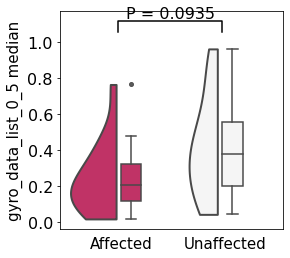

0.09352482094264832
9.57897521971125 9.641359938517112
25p_bubbles_acc_90-105



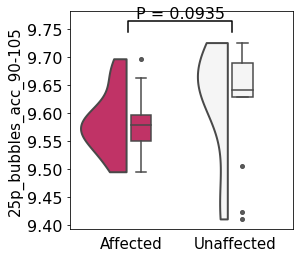

0.06276097745480774
0.07990317925335735 0.053902597114337425
5p_bubbles_gyro_105-120



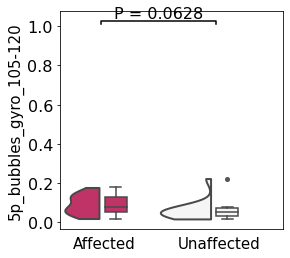

{'5p_bubbles_gyro_105-120', 'gyro_data_list_0_5 median', '25p_bubbles_acc_90-105'}
-------------------------------------------


In [18]:
test_list = list(data_and_demographics.columns)
test_list_sum = [x for x in test_list if 'sum' in x]
test_list_median = [x for x in test_list if 'median' in x]
test_list_95perc = [x for x in test_list if '95p' in x]
test_list_5perc = [x for x in test_list if '5p' in x]
test_list_75perc = [x for x in test_list if '75p' in x]
test_list_25perc = [x for x in test_list if '25p' in x]
test_list_std = [x for x in test_list if 'std' in x]
test_list_var = [x for x in test_list if 'var' in x]

test_list = test_list_sum + test_list_median + test_list_75perc+test_list_25perc+ test_list_95perc+test_list_5perc+test_list_std + test_list_var

sig_list = test_difference_KSADSgen(test_list,data_and_demographics)
print(set(sig_list))
print('-------------------------------------------')


### Test for Correlative Significance

In [19]:
new_data_and_demographics = data_and_demographics.copy()
columns_to_keep = list(redcap.columns) + test_list
new_data_and_demographics = new_data_and_demographics[columns_to_keep]
new_data_and_demographics = new_data_and_demographics[new_data_and_demographics['KSADSintDX'] > 0]
new_data_and_demographics = new_data_and_demographics.drop(columns = ['childid','CBCLintGmax','KSADSintDX','Diagnosis','childageYears'])
#new_data_and_demographics = new_data_and_demographics.drop(columns = ['childid','childrace','ethnicity','childsex','childageYears','childageMonths','record_id'])
new_data_and_demographics = new_data_and_demographics.loc[:,~new_data_and_demographics.columns.duplicated()]

#diagnosis_list = ['CBCLintGmax','KSADSintDX','KSADSintSX']
diagnosis_list = ['KSADSintSX']

diagnosis_to_feats = {}

for_dataframes = []
for x in diagnosis_list:
    features = []
    print(x)
    diagnosis_to_feats[x] = []
    #get correlations of each features in dataset
    corrmat = new_data_and_demographics.corr()

    new_data_frame = corrmat[x].to_frame().reset_index()
    new_data_frame.columns = ['feature','feature_correlation']
    new_data_frame = new_data_frame.sort_values(by='feature_correlation')

    top_neg = new_data_frame[:15]['feature_correlation']
    top_pos = new_data_frame[-15:]['feature_correlation']

    top_neg_labels = new_data_frame[:15]['feature']
    top_pos_labels = new_data_frame[-15:]['feature']

    #print(top_neg_labels)
    values = list(top_neg.values) + list(top_pos.values)
    labels = list(top_neg_labels.values) + list(top_pos_labels.values)

    #plt.figure(figsize = (12,8))
    #sns.barplot(values,labels)
    #plt.show()

    correlative = []

    for y in labels:
        if (y!= 'childageMonths') and (y!= 'childgender1') and (y!=x):
            partial_corr = pg.partial_corr(data = new_data_and_demographics, x = y,y = x,method='spearman')
            if partial_corr['p-val'].iloc[0] < .1:
                if y not in diagnosis_list:
                    print(y,x)
                    print(partial_corr)
                    diagnosis_to_feats[x].append(y)
                    correlative.append(y)
    print()

    
    print('--------------')

KSADSintSX
median_bubbles_acc_150-165 KSADSintSX
           n         r           CI95%     p-val
spearman  14 -0.652669  [-0.88, -0.19]  0.011398
25p_bubbles_acc_165-180 KSADSintSX
           n         r           CI95%     p-val
spearman  14 -0.623908  [-0.87, -0.14]  0.017102
sum_bubbles_acc_135-150 KSADSintSX
           n         r           CI95%     p-val
spearman  14 -0.630545  [-0.87, -0.15]  0.015626
median_bubbles_acc_0-15 KSADSintSX
           n         r          CI95%     p-val
spearman  14 -0.694706  [-0.9, -0.26]  0.005826
25p_bubbles_acc_0-15 KSADSintSX
           n        r          CI95%     p-val
spearman  14 -0.70798  [-0.9, -0.28]  0.004608
25p_bubbles_acc_150-165 KSADSintSX
           n         r         CI95%     p-val
spearman  14 -0.464612  [-0.8, 0.09]  0.094172
sum_bubbles_acc_75-90 KSADSintSX
           n         r           CI95%     p-val
spearman  14 -0.621695  [-0.87, -0.14]  0.017617
5p_bubbles_gyro_90-105 KSADSintSX
           n         r          CI95